# PAN DETAILS EXTRACTION

**Notebook is divided into 3 parts and all the code has been moduled into functions:**

I made two ways of extracting details from the newpan card and one way from the oldpan card.

I tried my best for foreground and background segmentation with grabcut algorithm and morphological operations.

I will have to switch to neural network segmentation.

These ways work perfectly for properly cropped images with adequate brightness 
(Not too bright) and decent camera quality.

##  NEW PAN CARD DETAILS EXTRACTION BY QR CODE

    This method makes use of morphological operations to get the qr 
    and then uses the library pyzbar to get the information from the qr.

In [1]:
!sudo apt-get update
!sudo apt-get install tesseract-ocr
!sudo apt-get install libtesseract-dev

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesse

In [2]:
! sudo apt-get install libzbar0
! pip install pyzbar
! pip install xmltodict

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libzbar0 is already the newest version (0.10+doc-10.1build2).
0 upgraded, 0 newly installed, 0 to remove and 108 not upgraded.


In [3]:
!pip install tesseract
!pip install tesseract-ocr
!pip install pytesseract

In [0]:
import numpy as np
import cv2
import imutils
import pytesseract
from pyzbar import pyzbar
import xmltodict
from google.colab.patches import cv2_imshow
import re

In [0]:
def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) * (br[0] - bl[0])) + ((br[1] - bl[1]) * (br[1] - bl[1])))
    widthB = np.sqrt(((tr[0] - tl[0]) * (tr[0] - tl[0])) + ((tr[1] - tl[1]) * (tr[1] - tl[1])))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) * (tr[0] - br[0])) + ((tr[1] - br[1]) * (tr[1] - br[1])))
    heightB = np.sqrt(((tl[0] - bl[0]) * (tl[0] - bl[0])) + ((tl[1] - bl[1]) * (tl[1] - bl[1])))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the warped image
    return warped
    
def order_points(pts):
  # initialzie a list of coordinates that will be ordered
  # such that the first entry in the list is the top-left,
  # the second entry is the top-right, the third is the
  # bottom-right, and the fourth is the bottom-left
  rect = np.zeros((4, 2), dtype = "float32")
  s = pts.sum(axis = 1)
  rect[0] = pts[np.argmin(s)]
  rect[2] = pts[np.argmax(s)]
  diff = np.diff(pts, axis = 1)
  rect[1] = pts[np.argmin(diff)]
  rect[3] = pts[np.argmax(diff)]
  return rect

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [0]:
def get_qr_image(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  thresh= get_thresh_image(gray)
  cv2_imshow(thresh)
  opening= get_final_morph_img(thresh)
  cv2_imshow(opening)
  box=get_qr_contour(opening)
  qr=crop_qr(box)
  return qr  

def get_thresh_image(gray):
  # compute the Scharr gradient magnitude representation of the images
  # in both the x and y direction
  gradX = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = -1)
  gradY = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 0, dy = 1, ksize = -1)
  # subtract the y-gradient from the x-gradient
  gradient = cv2.subtract(gradX, gradY)
  gradient = cv2.convertScaleAbs(gradient)
  blurred = cv2.blur(gradient, (5, 5))
  (x, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)
  return thresh

def get_final_morph_img(thresh):
  # construct a closing kernel and apply it to the thresholded image
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 7))
  closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
  # Morphological operations : Erosions and dilations.
  closed = cv2.erode(closed, None, iterations = 3)
  closed = cv2.dilate(closed, None, iterations = 4)
  # construct an opening kernel and apply it to the thresholded image
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 5))
  opening = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)
  return opening

def get_qr_contour(opening):
  contours, hierarchy = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cntrs = sorted(contours, key = cv2.contourArea, reverse = True)[0]
  rect = cv2.minAreaRect(cntrs)
  box = np.int0(cv2.boxPoints(rect))
  img=cv2.drawContours(image, [box], -1, (0, 0, 255), 1)
  cv2_imshow(img)
  return box  

def crop_qr(box):
  finimg = four_point_transform(image, box)
  finimg = increase_brightness(finimg, value=2)
  qr = finimg[2:(finimg.shape[0]-1), 2:(finimg.shape[1]-1)]
  return qr

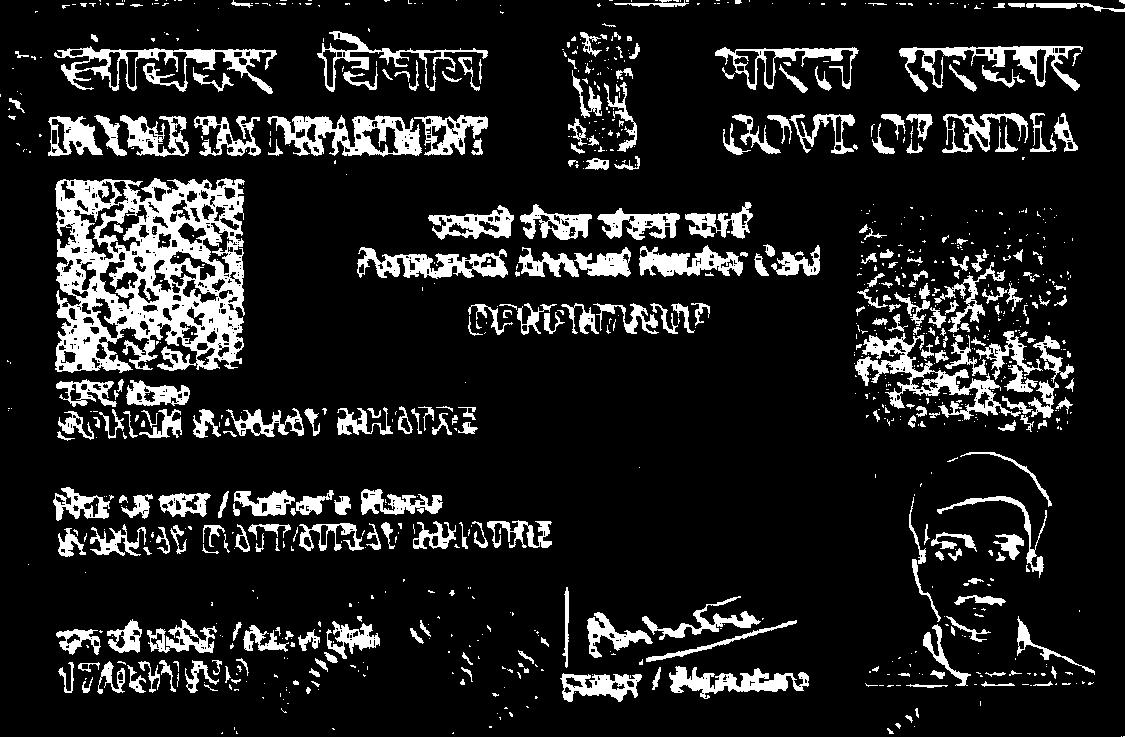

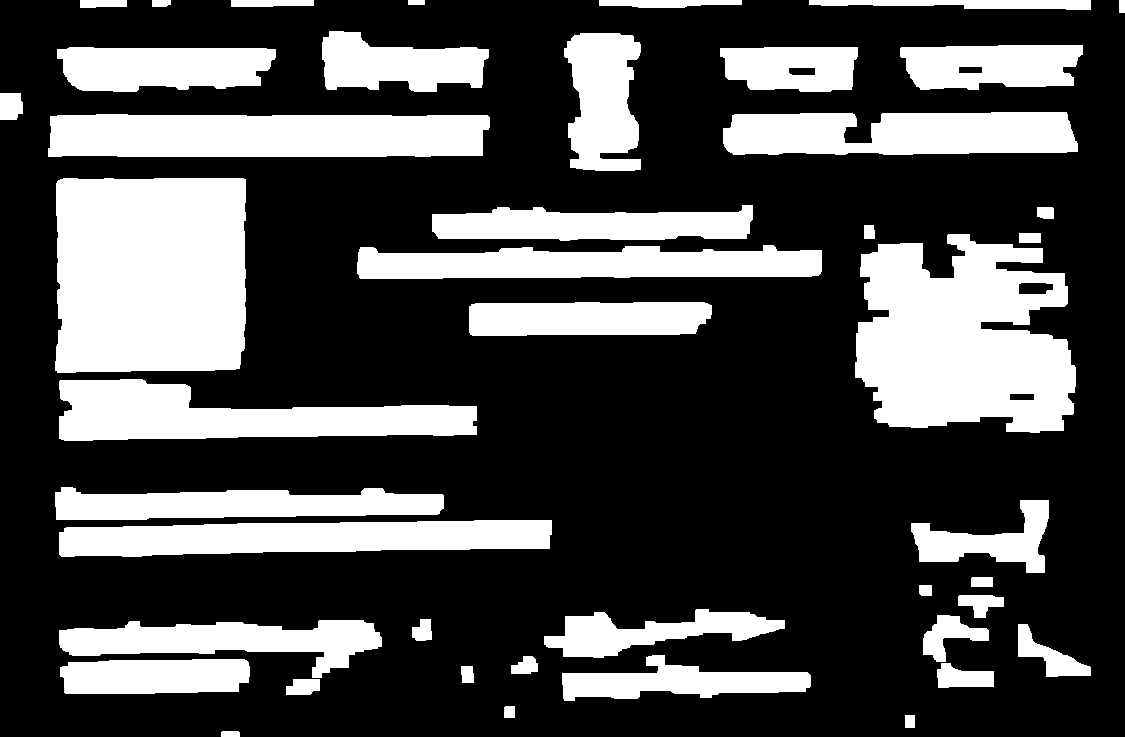

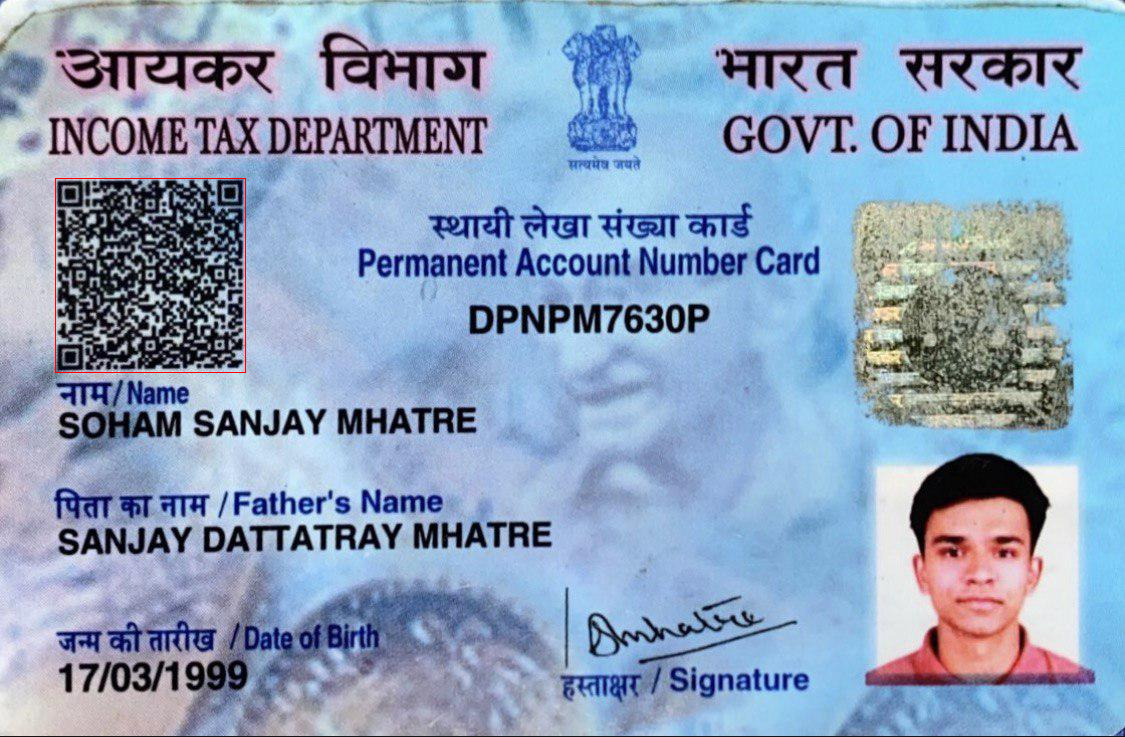

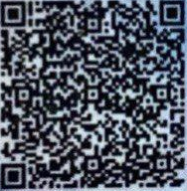

In [7]:
image=cv2.imread('newpan.jpg')
qr=get_qr_image(image)
cv2_imshow(qr)

In [0]:
def scanqr(image):
    barcodes = pyzbar.decode(image)
    if len(barcodes) != 1 : 
        print('qr not cropped properly') # default list returned detected more than 1 barcodes or no barcodes
        return {}
    barcode = barcodes[0]
    qrdata= barcode.data.decode("utf-8")
    output=qrdata.splitlines()
    return output

In [9]:
scanqr(qr)

['Name / नाम : SOHAM SANJAY MHATRE',
 "Father's Name / पिता का नाम : SANJAY DATTATRAY MHATRE",
 'DOB / जन्म की तारीख : 17/03/1999',
 'PAN / पैन : DPNPM7630P']

**The scan qr format can be changed. All formats can be changed to return a dictionary or added to a dataframe with the respective columns.**

## NEW PAN DETAILS EXTRACTION USING MORPHOLOGICAL OPERATIONS, THRESHOLDING, TESSERACT AND REGEX
    Will work successfuly with adequately bright images.
    1.def newpan_details(image):
      returns the details of newpan image. Accuracy depends on tesseract.

    2.def newpan_junk(l,image):
      takes the junk image contours and converts them into list of strings.
    
    3.def newpan_contour_list(image):
      gets details contours from pan card image.

In [0]:
def newpan_details(image):
  contours=newpan_contour_list(image)
  junk=newpan_junk(contours,image)
  details=newpan_valid_info(junk)
  return details

def newpan_junk(l,image):
  image = imutils.resize(image, width=600)
  junk=[]
  for i in range(0,10):
    finimg = four_point_transform(image, l[i])
    finimg = increase_brightness(finimg, value=10)
    finimg = get_grayscale(finimg)  
    qr = finimg[2:(finimg.shape[0]-1), 2:(finimg.shape[1]-1)]  
    cv2_imshow(finimg)
    junk.append(pytesseract.image_to_string(finimg))
  return junk

def newpan_contour_list(image):
  gray=newpan_image_processing(image)
  cv2_imshow(gray)
  gradient=newpan_gradient_thresh(gray)
  cv2_imshow(gradient)
  closed=newpan_morph_ops(gradient)
  cv2_imshow(closed)
  contours=newpan_contours(closed,image)
  return contours
  
def newpan_image_processing(image):
  rem_noise = cv2.fastNlMeansDenoisingColored(image,None,25,10,7,21)
  rem_noise = imutils.resize(rem_noise, width=600)
  image = imutils.resize(image, width=600)
  gray = cv2.cvtColor(rem_noise, cv2.COLOR_BGR2GRAY)
  return gray

def newpan_gradient_thresh(gray):
  (x,thresh)=cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)
  # compute the Scharr gradient magnitude representation of the images
  # in both the x and y direction
  gradX = cv2.Sobel(thresh, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = -1)
  gradY = cv2.Sobel(thresh, ddepth = cv2.CV_32F, dx = 0, dy = 1, ksize = -1)
  # subtract the y-gradient from the x-gradient
  gradient = cv2.subtract(gradX, gradY)
  gradient = cv2.convertScaleAbs(gradient)
  return gradient

def newpan_morph_ops(gradient):
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
  closed = cv2.morphologyEx(gradient, cv2.MORPH_CLOSE, kernel)
  closed = cv2.erode(closed, None, iterations = 2)
  closed = cv2.dilate(closed, None, iterations = 5)
  return closed  

def newpan_contours(closed,image):
  image = imutils.resize(image, width=600)
  contours, hierarchy = cv2.findContours(closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cntrs = sorted(contours, key = cv2.contourArea, reverse = True)[0:10]
  contours=[]
  for c in cntrs:
    rect = cv2.minAreaRect(c)
    box = np.int0(cv2.boxPoints(rect))
    contours.append(box)  
    # Draw bounding boxes around the detected contours and display it on original image
    cv2.drawContours(image, [box], -1, (0, 0, 255), 1)
  cv2_imshow(image)  
  l=contours
  return l 

In [0]:
def newpan_valid_info(junk):
  y=list_split_newline(junk)
  x=[]
  for i in range(len(y)): 
      x.append(re.sub('[^A-Z0-9/]', ' ', y[i]))
  x=empty_removal(x)    
  date=get_date(x)
  pan=get_pan(x)
  details=[x[0],x[1],date,pan]
  return details 
  
def list_split_newline(junk):
  x=[]
  for i in range(len(junk)): 
    x.append(re.sub(r'^.*?\n', '', junk[i]))
  return x     

# removes empty elements
def empty_removal(x):
  y=[]
  for i in range(len(x)):
    if x[i]!='':
      y.append(x[i]) 
  return y  

def get_date(y):
  a=[]
  for i in range(len(y)):
    a.append(re.findall("[\d]{1,2}/[\d]{1,2}/[\d]{4}", y[i]))
  for i in range(len(a)):
    if a[i]!=[]:
      date=a[i]
  date=re.sub('[^0-9/]', '', str(date))    
  return date   

def get_pan(x):
  z=[]
  for i in range(len(x)): 
    z.append(re.findall("^[A-Z0-9]+$", x[i]))
  for i in range(len(z)):
      if z[i]!=[]:
        pan=z[i]
  pan=re.sub('[^A-Z0-9]', '', str(pan))      
  return pan

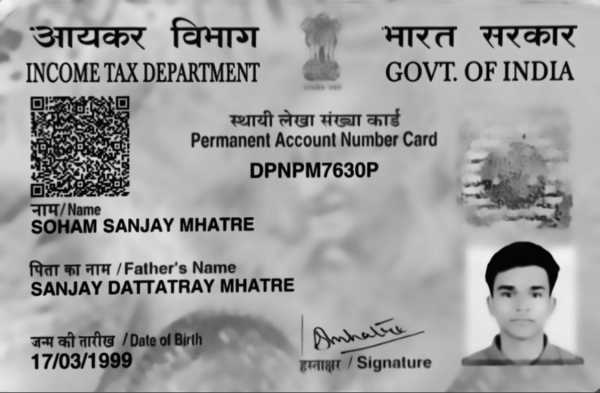

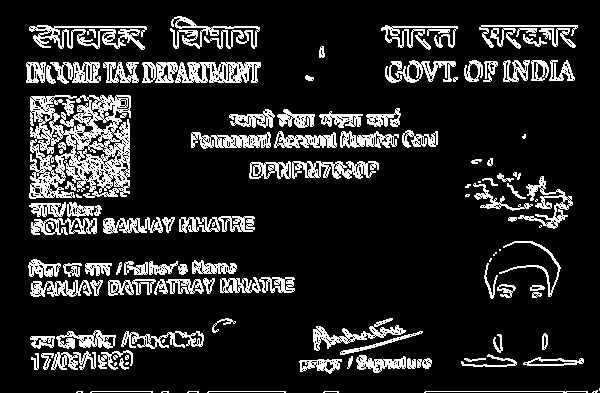

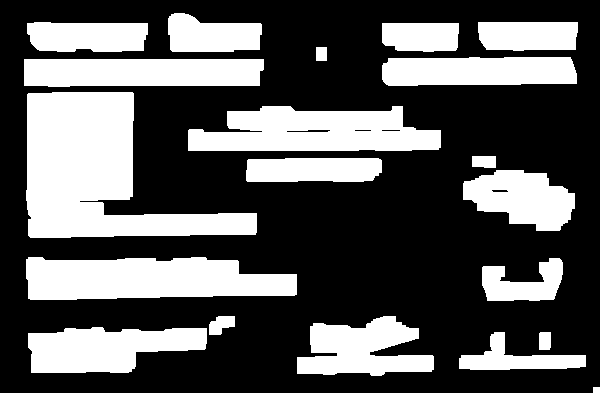

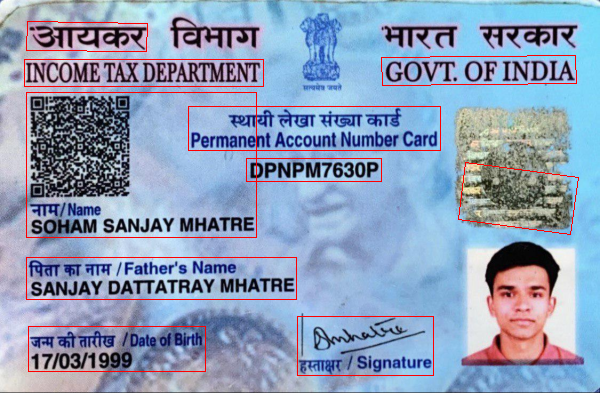

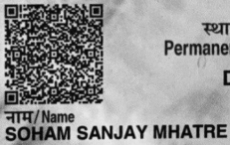

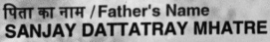

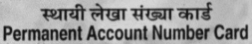

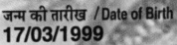

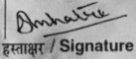

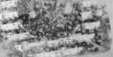

['ATA/Name\nSOHAM SANJAY MHATRE',
 "fttar er ATH / Father's Name\nSANJAY DATTATRAY MHATRE",
 'eared cran emt ars\nPermanent Account Number Card',
 'INCOME TAX DEPARTMENT',
 'wt arate /Date Of Birth\n17/03/1999 = >”',
 '| Bae\ngear / Signature',
 '',
 '',
 '',
 'DPNPM7630P']

In [12]:
image=cv2.imread('newpan.jpg')
contours=newpan_contour_list(image)
newpan_junk(contours,image)

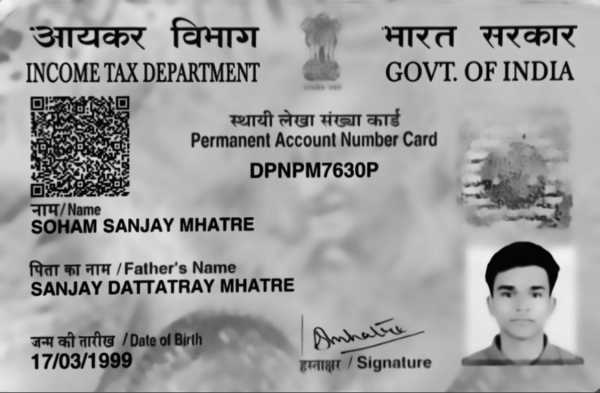

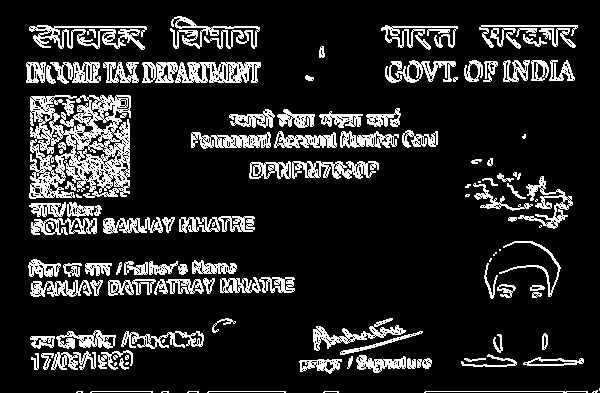

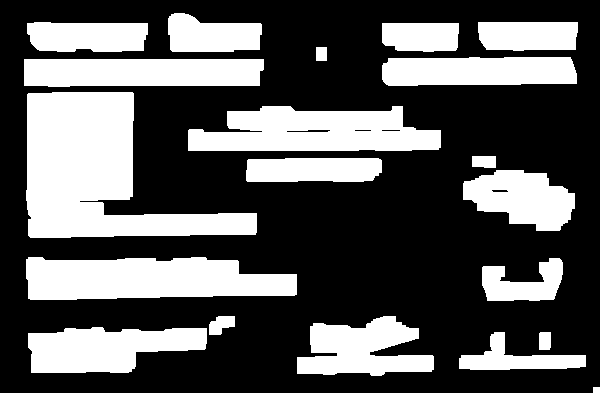

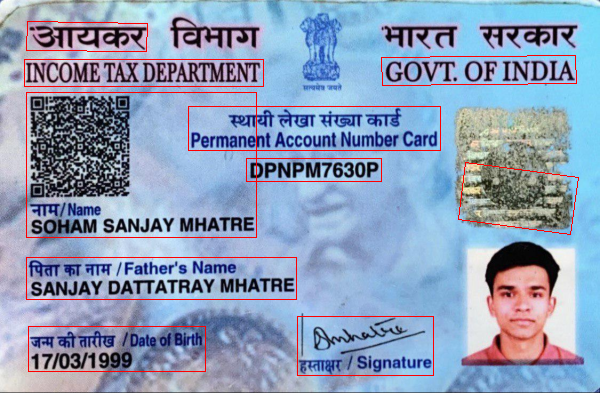

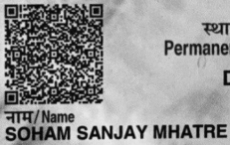

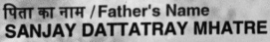

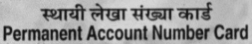

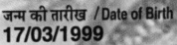

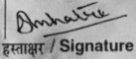

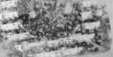

In [13]:
details=newpan_details(image)

In [14]:
print(details)

['SOHAM SANJAY MHATRE', 'SANJAY DATTATRAY MHATRE', '17/03/1999', 'DPNPM7630P']


## OLD PAN CARD DETAILS EXTRACTION USING PRE-DEFINED REGION AREA

    Since old pancards have a very well defined region for details,
    those regions can be directly targeted by tesseract.
    Successful extraction.

In [0]:
def oldpan_details(image):
  image = increase_brightness(image, value=30)
  image = imutils.resize(image, width=600)
  cv2_imshow(image)
  #(height from above): (height from below), (width from left): (width from right)
  oldpan_det = image[int(0.24*image.shape[0]):(image.shape[0]-int(0.24*image.shape[0])), int(0.01*image.shape[1]):(image.shape[1]-int(0.30*image.shape[1]))]
  cv2_imshow(oldpan_det)
  gray = cv2.cvtColor(oldpan_det, cv2.COLOR_BGR2GRAY)
  details=oldpan_info_extraction(gray)
  return details

def oldpan_info_extraction(gray):
  x=pytesseract.image_to_string(gray).splitlines()
  y=empty_removal(x)
  info=valid_info(y)
  info=empty_removal(info)
  return info 

# removes empty elements
def empty_removal(x):
  y=[]
  for i in range(len(x)):
    if x[i]!='':
      y.append(x[i]) 
  return y   

# removes small letters wrongly interpreted by tesseract
def valid_info(y):
  x=[]
  for i in range(len(y)): 
      x.append(re.sub('[^A-Z0-9/]', ' ', y[i]))  
  x[3]=x[4]
  x=x[0:4]
  return x     

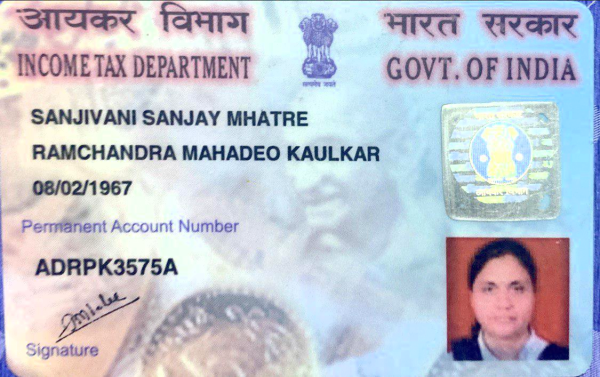

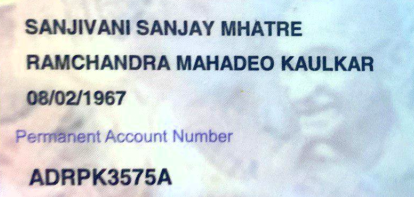

['SANJIVANI SANJAY MHATRE',
 'RAMCHANDRA MAHADEO KAULKAR',
 '08/02/1967',
 'ADRPK3575A']

In [16]:
image=cv2.imread('oldpan.jpg')
oldpan_details(image)